In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import xgboost as xgb #BDT

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-scikit-learn/0.19.1/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
samples = ["ttw", "ttz"]

df = []
for sample in samples:
    # Retrieve TTree
    f = uproot.open("hadds/extraJetsBDT_Run2/{}.root".format(sample))
    tree = f.get("variable")
    temp_df = tree.pandas.df(branches="MVA_*", flatten=True)
    df.append(temp_df)

df = pd.concat(df)
# Remove "MVA" prefix from column names
df.columns = df.columns.str.split("MVA_").str.get(1)

In [3]:
# Make a preliminary cut on Mjj
df = df[np.abs(df.extra_jet_pair_M - 80.379) < 30]
outside_df = df[np.abs(df.extra_jet_pair_M - 80.379) > 30].copy()

In [19]:
# Get bookkeeping columns to exclude in training
excludes = ["run", "event", "lumi", "extra_jet_pair_is_match"]
    
# Collect selected features
features = sorted(list(set(df.columns.values)-set(excludes)))

In [20]:
np.any(df[df.extra_jet_pair_is_match].event.value_counts() > 1)

False

In [21]:
df.event.nunique()

4354

In [22]:
df[df.extra_jet_pair_is_match].size

58968

In [23]:
df[~df.extra_jet_pair_is_match].size

60942

In [24]:
features

[u'extra_jet_pair_M',
 u'extra_jet_pair_dR',
 u'extra_jet_pair_ld_eta',
 u'extra_jet_pair_ld_phi',
 u'extra_jet_pair_ld_pt',
 u'extra_jet_pair_ld_qg_disc',
 u'extra_jet_pair_tr_eta',
 u'extra_jet_pair_tr_phi',
 u'extra_jet_pair_tr_pt',
 u'extra_jet_pair_tr_qg_disc']

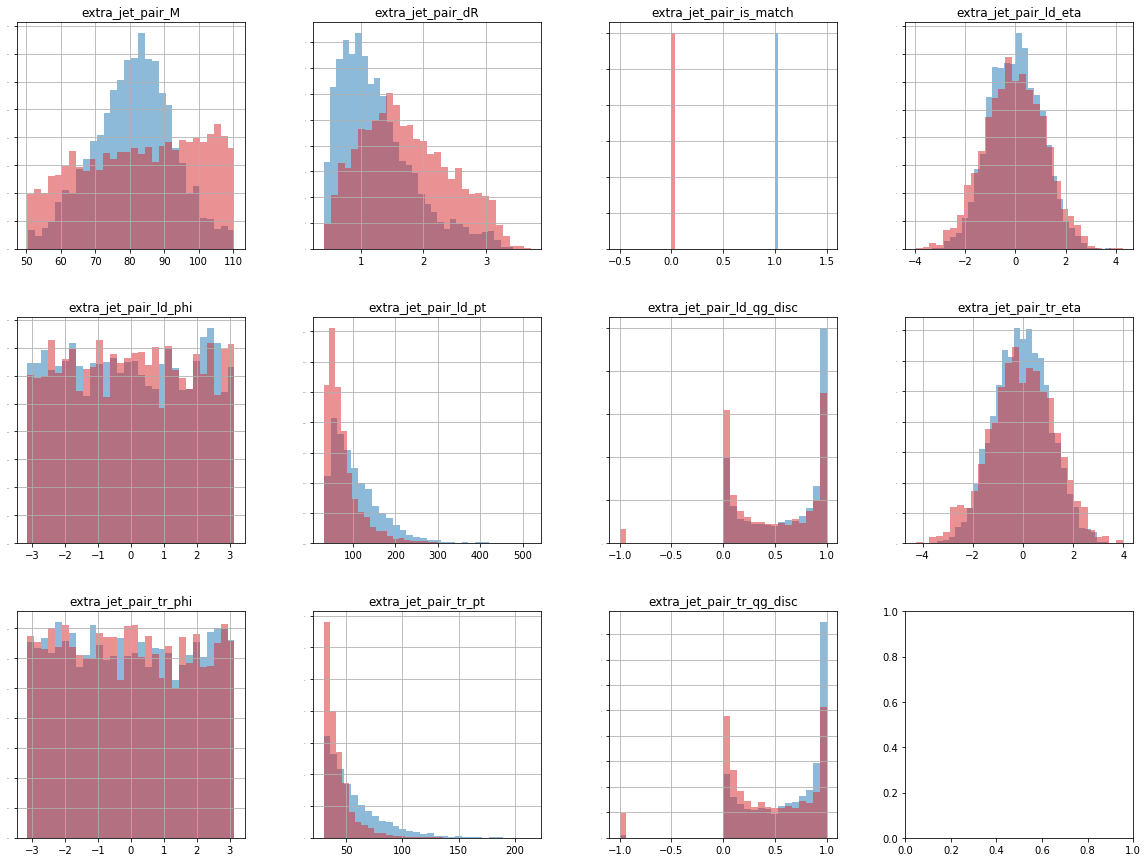

In [25]:
extras = ["extra_jet_pair_is_match"]

fig, axes = plt.subplots(3,4,figsize=(20,15))
df[df.extra_jet_pair_is_match][features + extras].hist(
    ax=axes.flatten()[:len(features + extras)], 
    alpha=0.5, 
    color="C0", 
    ylabelsize=0, 
    density=True, 
    bins=30
);
df[~df.extra_jet_pair_is_match][features + extras].hist(
    ax=axes.flatten()[:len(features + extras)], 
    alpha=0.5, 
    color="C3", 
    ylabelsize=0, 
    density=True, 
    bins=30
);

In [26]:
# Split dataframe for training and testing
dummy_weights = np.ones(df.extra_jet_pair_is_match.size) # in place of dfs["weights"]
x_train, x_test, y_train, y_test, weights_train, weights_test = train_test_split(
    df,
    df.extra_jet_pair_is_match,
    dummy_weights,
    test_size=0.25, 
    random_state=42,
)

print("Training Data: {}".format(x_train.shape))
print("Testing Data: {}".format(x_test.shape))

Training Data: (6423, 14)
Testing Data: (2142, 14)


In [27]:
events_train, events_test = train_test_split(df.event.unique(), test_size=0.25, random_state=42)

In [28]:
x_train = df[np.isin(df.event, events_train)]
y_train = x_train.extra_jet_pair_is_match
weights_train = np.ones(y_train.size)
x_test = df[np.isin(df.event, events_test)]
y_test = x_test.extra_jet_pair_is_match
weights_test = np.ones(y_test.size)

print("Training Data: {}".format(x_train.shape))
print("Testing Data: {}".format(x_test.shape))

Training Data: (6447, 14)
Testing Data: (2118, 14)


In [29]:
# BDT Input
dtrain = xgb.DMatrix(x_train[features], label=y_train, weight=np.abs(weights_train))
dtest = xgb.DMatrix(x_test[features], label=y_test, weight=np.abs(weights_test))
evallist = [(dtrain,'train'), (dtest,'eval')]

# BDT Parameters Setup
param = {}
param['objective'] = 'binary:logistic'

# BDT Knobs (Parameters)
num_round = 200                 # Number of training rounds
param['eta'] = 0.1              # Step size shrinkage (alias: learning_rate)
param['max_depth'] = 3          # Max. depth of tree: larger = more complex = more prone to overfitting
param['verbosity'] = 1          # 0 (silent), 1 (warning), 2 (info), 3 (debug)
param['nthread'] = 12           # Number of parallel threads
param['eval_metric'] = "auc"    # Evaluation metrics for validation data. 'auc' = Area Under the Curve
param['subsample'] = 0.6        # Subsample ratio of the training instances
param['alpha'] = 8.0            # L1 regularization term on weights: Larger = more conservative
param['gamma'] = 2.0            # Min. loss rediction to make leaf (alias: min_split_loss)
param['lambda'] = 1.0           # L2 regularization term on weights: Larger = more conservative
param['min_child_weight'] = 1.0 # Minimum sum of instance weight (hessian) needed in a child
param['colsample_bytree'] = 1.0 # The subsample ratio of columns when constructing each tree

In [30]:
# Get pos/neg weights
sumw_pos = np.abs(dtrain.get_weight()[dtrain.get_label()==1]).sum()
sumw_neg = np.abs(dtrain.get_weight()[dtrain.get_label()==0]).sum()
param["scale_pos_weight"] = sumw_neg/sumw_pos

In [31]:
# Train
bst = xgb.train(param.items(), dtrain, num_round, evallist, early_stopping_rounds=15, verbose_eval=True)

[0]	train-auc:0.750124	eval-auc:0.738146
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 15 rounds.
[1]	train-auc:0.780846	eval-auc:0.764095
[2]	train-auc:0.788895	eval-auc:0.772019
[3]	train-auc:0.792666	eval-auc:0.777693
[4]	train-auc:0.796577	eval-auc:0.780762
[5]	train-auc:0.799475	eval-auc:0.783055
[6]	train-auc:0.802046	eval-auc:0.785219
[7]	train-auc:0.803691	eval-auc:0.784296
[8]	train-auc:0.803647	eval-auc:0.783951
[9]	train-auc:0.80483	eval-auc:0.785214
[10]	train-auc:0.807216	eval-auc:0.787893
[11]	train-auc:0.808292	eval-auc:0.789908
[12]	train-auc:0.808222	eval-auc:0.790806
[13]	train-auc:0.808611	eval-auc:0.79192
[14]	train-auc:0.809759	eval-auc:0.792426
[15]	train-auc:0.810712	eval-auc:0.793329
[16]	train-auc:0.812332	eval-auc:0.794846
[17]	train-auc:0.813395	eval-auc:0.796249
[18]	train-auc:0.814083	eval-auc:0.79713
[19]	train-auc:0.815425	eval-auc:0.799117
[20]	train-auc:0.816146	eval-auc

In [32]:
# Get predictions
preds_train = bst.predict(xgb.DMatrix(x_train[features]))
preds_test = bst.predict(xgb.DMatrix(x_test[features]))

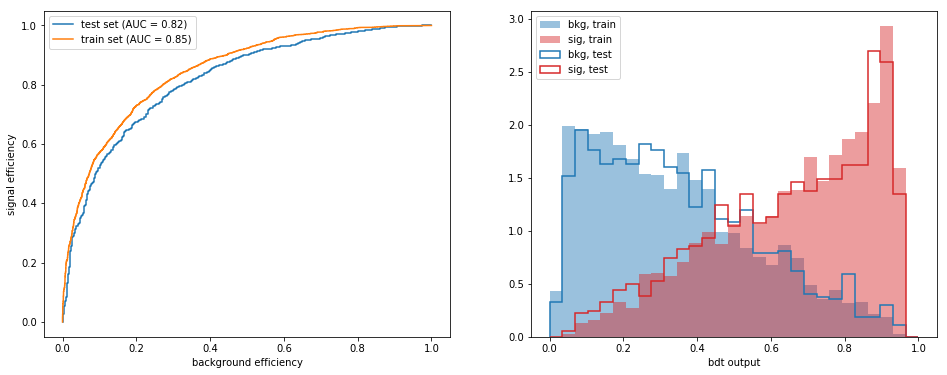

In [33]:
# Suplots setup
fig, axes = plt.subplots(1,2,figsize=(16,6))

# Subplot 1: Plot ROC curves
plt.subplot(1, 2, 1)
# Test ROC Curve
fpr, tpr, thresh = roc_curve(y_test,preds_test)
plt.plot(fpr, tpr, label="test set (AUC = {:.2f})".format(np.trapz(tpr,fpr)));
# Train ROC Curve
fpr, tpr, thresh = roc_curve(y_train,preds_train)
plt.plot(fpr, tpr, label="train set (AUC = {:.2f})".format(np.trapz(tpr,fpr)));
# Settings
plt.xlabel("background efficiency");
plt.ylabel("signal efficiency");
plt.legend();

# Subplot 2: Plot distribution of BDT outputs
plt.subplot(1, 2, 2)
bins = np.linspace(0.,1.,30)
# Training - Background
plt.hist(preds_train[y_train==0], weights=weights_train[y_train==0], bins=bins,histtype="stepfilled",alpha=0.45, 
         density=True, label="bkg, train",color="C0");
# Training - Signal
plt.hist(preds_train[y_train==1], weights=weights_train[y_train==1], bins=bins,histtype="stepfilled",alpha=0.45, 
         density=True, label="sig, train",color="C3");
# Testing - Background
plt.hist(preds_test[y_test==0], weights=weights_test[y_test==0], bins=bins,histtype="step",alpha=1.0, 
         density=True, label="bkg, test",color="C0", lw=1.5, linestyle="solid");
# Testing - Signal
plt.hist(preds_test[y_test==1], weights=weights_test[y_test==1], bins=bins,histtype="step",alpha=1.0, 
         density=True, label="sig, test",color="C3", lw=1.5, linestyle="solid");
# Settings
plt.xlabel("bdt output");
plt.legend(loc=2);

In [34]:
# Get cut scores
gain_score = pd.DataFrame(bst.get_score(importance_type='gain').items(), columns=['cut', 'gain'])
cover_score = pd.DataFrame(bst.get_score(importance_type='cover').items(), columns=['cut', 'cover'])
weight_score = pd.DataFrame(bst.get_score(importance_type='weight').items(), columns=['cut', 'weight'])
# Merge scores into single dataframe along 'cut' column
scores = reduce(lambda left, right: pd.merge(left,right,on='cut'), [gain_score, cover_score, weight_score])
# Display top ten cuts in 'gain'
scores_top10 = scores.sort_values('gain', ascending=False)[:10]
scores_top10

,cut,gain,cover,weight
6,extra_jet_pair_tr_pt,23.079210,405.963281,79
0,extra_jet_pair_M,17.923638,394.983501,162
7,extra_jet_pair_dR,17.167459,268.181739,62
9,extra_jet_pair_ld_pt,12.374005,395.720349,79
3,extra_jet_pair_tr_qg_disc,12.007203,453.967599,78
5,extra_jet_pair_ld_qg_disc,8.733359,454.011825,84
1,extra_jet_pair_ld_eta,3.592166,359.879542,56
4,extra_jet_pair_tr_eta,3.557665,344.307848,41
8,extra_jet_pair_ld_phi,3.316765,291.712455,33
2,extra_jet_pair_tr_phi,3.256359,372.189267,33


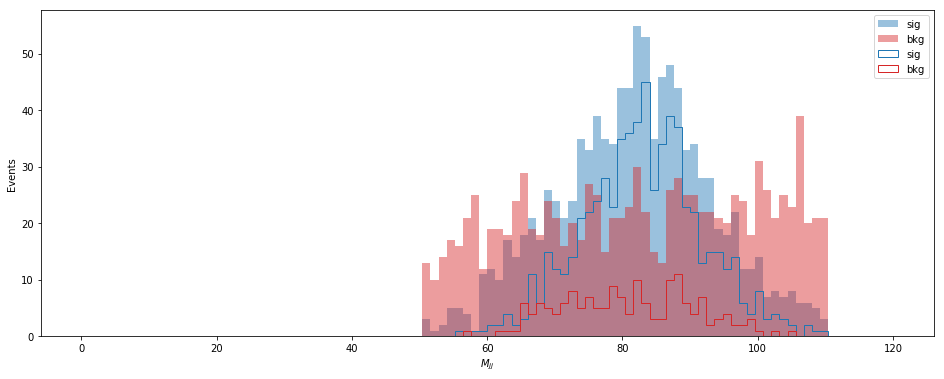

In [35]:
# Suplots setup
fig, axes = plt.subplots(1,1,figsize=(16,6))
bins = np.linspace(0, 120, 101)

# Subplot 1: Plot correlation btwn predictions and Higgs mass
plt.subplot(1, 1, 1)
# Correlation btwn predictions and Higgs mass
plt.hist(
    x_test["extra_jet_pair_M"][y_test == 1], 
    bins=bins, 
    histtype="stepfilled",
    alpha=0.45, 
    label="sig",
    color="C0"
)
plt.hist(
    x_test["extra_jet_pair_M"][y_test == 0], 
    bins=bins, 
    histtype="stepfilled",
    alpha=0.45, 
    label="bkg",
    color="C3"
)
plt.hist(
    x_test["extra_jet_pair_M"][(preds_test > 0.6) & (y_test == 1)], 
    bins=bins, 
    histtype="step",
    alpha=1.0, 
    label="sig",
    color="C0"
)
plt.hist(
    x_test["extra_jet_pair_M"][(preds_test > 0.6) & (y_test == 0)], 
    bins=bins, 
    histtype="step",
    alpha=1.0, 
    label="bkg",
    color="C3"
)
# Settings
# plt.yscale("log")
plt.xlabel("$M_{jj}$");
plt.ylabel("Events");
plt.legend();

In [36]:
df_ = x_test.copy()
df_["bdt"] = preds_test

n_bdt_true = 0
n_min_dR_true = 0
counter = 0
for evt in df_.event.unique():
    this_df_ = df_[df_.event == evt]
    n_bdt_true += (this_df_[this_df_.bdt == this_df_.bdt.max()].extra_jet_pair_is_match.values[0])
    n_min_dR_true += (this_df_[this_df_.extra_jet_pair_dR == this_df_.extra_jet_pair_dR.min()].extra_jet_pair_is_match.values[0])
    counter += 1

In [37]:
n_bdt_true*1.0/counter

0.8448117539026629

In [38]:
n_min_dR_true*1.0/counter

0.7658402203856749

In [39]:
# Write BDT model and test data to pickle file
pickle.dump(bst, open("bdt.pkl", "w"))
x_test.to_pickle("x_test.pkl", compression="gzip")
# Write features to JSON
with open("features.json", "w") as fout:
    json.dump(features, fout)
# Write scores table as LaTeX system
with open("bdt-vars.tex", "w") as fout:
    fout.write(scores_top10.to_latex())

In [45]:
bst.tojson()

AttributeError: 'Booster' object has no attribute 'tojson'

In [47]:
xgb.__version__

'0.72'

In [48]:
bst.save_model("bdt.json")

In [ ]:
# fig, axes = plt.subplots();

# df[df.extra_jet_pair_is_match].bdt.hist(
#     ax=axes,
#     bins=np.linspace(0,1,21),
#     alpha=0.5,
#     color="C0",
#     density=True,
#     label=r"$W\rightarrow q\bar{q}$"
# );
# df[~df.extra_jet_pair_is_match].bdt.hist(
#     bins=np.linspace(0,1,21), 
#     stacked=True, 
#     alpha=0.5,
#     color="C3",
#     label=r"not $W\rightarrow q\bar{q}$",
#     density=True
# );

# plt.legend();
# plt.xlabel("bdt output");

In [ ]:
# fig, axes = plt.subplots();

# outside_df[outside_df.extra_jet_pair_is_match].bdt.hist(
#     ax=axes,
#     bins=np.linspace(0,1,21),
#     alpha=0.5,
#     color="C0",
#     density=True,
#     label=r"$W\rightarrow q\bar{q}$"
# );
# outside_df[~outside_df.extra_jet_pair_is_match].bdt.hist(
#     bins=np.linspace(0,1,21), 
#     stacked=True, 
#     alpha=0.5,
#     color="C3",
#     label=r"not $W\rightarrow q\bar{q}$",
#     density=True
# );

# plt.legend();
# plt.xlabel("bdt output");

In [ ]:
# fig, axes = plt.subplots();

# df.extra_jet_pair_M.hist(
#     ax=axes,
#     bins=np.linspace(50,110,12),
#     alpha=0.5,
#     color="C0",
#     edgecolor="blue",
#     linewidth=2,
#     histtype="stepfilled",
#     density=True,
#     label="All"
# );

# df[df.bdt < 0.6].extra_jet_pair_M.hist(
#     ax=axes,
#     bins=np.linspace(50,110,12),
#     alpha=0.5,
#     color="C2",
#     edgecolor="green",
#     linewidth=2,
#     histtype="stepfilled",
#     density=True,
#     label="Pass"
# );

# df[df.bdt >= 0.6].extra_jet_pair_M.hist(
#     ax=axes,
#     bins=np.linspace(50,110,12),
#     alpha=0.5,
#     color="C3",
#     edgecolor="red",
#     linewidth=2,
#     histtype="stepfilled",
#     density=True,
#     label="Fail"
# );
# plt.xlabel(r"$M_{jj}$", size=18)

# plt.legend();